In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
from tensorflow.keras.applications import ResNet50,EfficientNetB0, MobileNet,InceptionV3         
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torchvision.models as models

2025-10-21 16:39:47.521098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761064787.783968      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761064787.861809      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 50

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 375 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names
class_names

['Akbar', 'Dilkash', 'urooj']

In [54]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [52]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
len (val_ds)

1

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [63]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=15,          
    restore_best_weights=True  
)


# ResNet50

In [64]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False

In [65]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(n_classes, activation='softmax')(top_model)
    return top_model

In [66]:
FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

In [67]:
resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [68]:
history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4332 - loss: 15.0464 - val_accuracy: 0.7500 - val_loss: 12.2816
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7133 - loss: 12.0195 - val_accuracy: 0.8125 - val_loss: 10.2678
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7344 - loss: 10.1141 - val_accuracy: 0.8594 - val_loss: 8.5981
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7534 - loss: 8.4773 - val_accuracy: 0.9219 - val_loss: 7.2104
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8037 - loss: 7.0990 - val_accuracy: 0.9219 - val_loss: 6.0440
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8688 - loss: 5.9727 - val_accuracy: 0.9062 - val_loss: 5.1383
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8373 - loss: 5.1237 - val_accuracy: 0.9531 - val_loss: 4.3959
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8595 - loss: 4.3935 - val_accuracy: 0.9531 - val_lo

**Accuracy on test Dataset**

In [69]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    preds = resnet.predict(images, verbose=0)
    preds = preds.argmax(axis=-1)  
    predictions.extend(preds)

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='macro')  
recall = recall_score(true_labels, predictions, average='macro') 
f1 = f1_score(true_labels, predictions, average='macro')  
accuracy = accuracy_score(true_labels, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


Precision: 0.8923
Recall:    0.9121
F1-Score:  0.8958
Accuracy:  0.9062


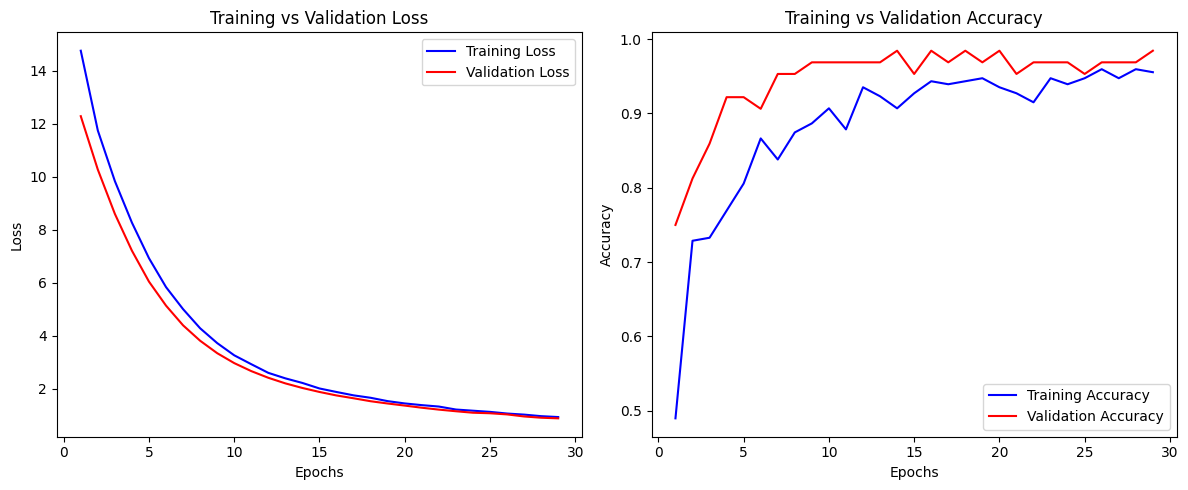

In [70]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**

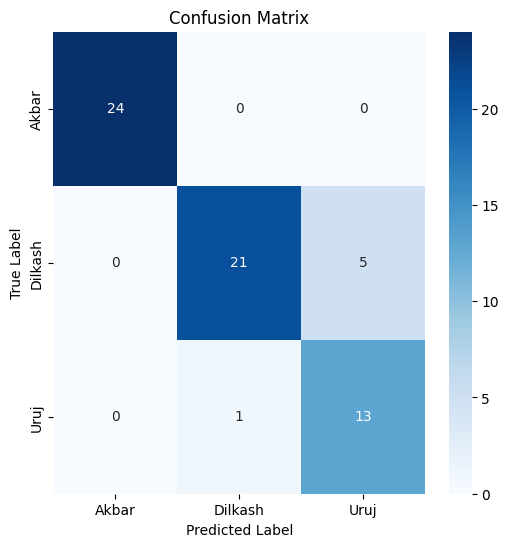

In [73]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
print(history.history.keys())


dict_keys(['accuracy', 'loss'])


# Effecient Net

In [ ]:
efficientnet= EfficientNetV2L(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

In [ ]:
FC_Head2 = lw(efficientnet, 4)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)

In [ ]:
efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])

In [ ]:


googlenet = models.googlenet(pretrained=True)
